<a href="https://colab.research.google.com/github/dany25-09/AlgorithmsUN2024II/blob/main/LabATQ/cagarciach_LabATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [46]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [47]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-x58agedg
  Resolved https://github.com/quantiacs/toolbox.git to commit 568159460bcffea00317cd4a8ef57ad1b0eb4141
  Preparing metadata (setup.py) ... done


In [48]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4079    0  4079    0     0   9381      0 --:--:-- --:--:-- --:--:--  9377
100  517k  100  517k    0     0   608k      0 --:--:-- --:--:-- --:--:--  608k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4099    0  4099    0     0  12450      0 --:--:-- --:--:-- --:--:-- 12421
100  392k  100  392k    0     0   538k      0 --:--:-- --:--:-- --:--:--  538k


In [49]:
import os

os.environ['API_KEY'] = 'b20ab326-9c07-411a-a3d9-a10d306126ff'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'


In [50]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [51]:
# loading nasdaq-100 stock data

stock_data = qndata.stocks.load_spx_data(
    tail=365 * 5,
    assets = [
        "NAS:AAPL", "NAS:AMZN", "NAS:MSFT", "NAS:NVDA", "NAS:GOOGL",
        "NAS:TSLA", "NAS:META", "NAS:AMD", "NAS:ADBE", "NAS:AVGO",
        "NAS:ASML", "NAS:PYPL", "NAS:NFLX", "NAS:QCOM", "NAS:INTC",
        "NAS:CSCO", "NAS:TXN", "NAS:CRWD", "NAS:SNOW", "NAS:PLTR"
    ]
)

# Seleccioné estos 20 assets por su destacada posición en sectores clave de la tecnología,
# como semiconductores, inteligencia artificial, servicios en la nube y redes sociales.
# Empresas como AAPL, AMZN, MSFT y GOOGL dominan sus respectivos mercados, siendo líderes en
# innovación y rentabilidad. NVDA y AMD son esenciales en la industria de los chips gráficos,
# mientras que TSLA destaca en vehículos eléctricos y energía renovable. Otras como META y SNOW
# lideran en el metaverso y análisis de datos, respectivamente. Además, empresas como CSCO y QCOM
# impulsan la conectividad y redes, con un crecimiento continuo en la era digital, estos assets
# representan empresas clave que ofrecen un crecimiento sostenible y están posicionadas para
# aprovechar las tendencias tecnológicas emergentes.

| |     #                                        | 442846 Elapsed Time: 0:00:00


fetched chunk 1/1 1s
Data loaded 1s


In [52]:
def get_features(data):
  """Builds the features used for learning:
      * a trend indicator;
      * the moving average convergence divergence;
      * a volatility measure;
      * the stochastic oscillator;
      * the relative strength index;
      * the logarithm of the closing price.
      These features can be modified and new ones can be added easily.
  """

  # the logarithm of the closing price:
  price = data.sel(field="close").ffill("time").bfill("time").fillna(0)  # fill NaN
  price = np.log(price)
  price = price.assign_coords(field="price")
  # El logaritmo del precio de cierre ayuda a normalizar los valores y mitigar grandes fluctuaciones.

  # the relative strength index (RSI):
  rsi = qnta.rsi(data.sel(field="close"))
  rsi = rsi.assign_coords(field="rsi")
  # El RSI mide la velocidad y el cambio de los movimientos de precios, lo que ayuda a identificar condiciones de sobrecompra o sobreventa.

  # the stochastic oscillator:
  k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
  d = d.assign_coords(field="stochastic_d")
  # El oscilador estocástico ayuda a identificar posibles puntos de reversión de precios.

  # trend indicator (ROC):
  trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
  trend = trend.assign_coords(field="trend")
  # El indicador de tendencia mide la variación del precio a lo largo del tiempo, ayudando a identificar la dirección general del mercado.

  # volatility measure:
  volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
  volatility = volatility / data.sel(field="close")
  volatility = qnta.lwma(volatility, 14)
  volatility = volatility.assign_coords(field="volatility")
  # La volatilidad mide la magnitud de las fluctuaciones de precios, lo que puede ayudar a evaluar el riesgo en el mercado.

  # moving average convergence divergence (MACD):
  macd = qnta.macd(data.sel(field="close"))
  macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
  macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
  macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")
  # El MACD es un indicador de momentum que ayuda a identificar cambios en la dirección de la tendencia del precio.

  # On-Balance Volume (OBV):
  if 'volume' in data.field:
      obv = data.sel(field="close")
      volume = data.sel(field="volume")
      obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
  else:
      # If 'volume' is not present, fill with 1s
      obv = xr.ones_like(data.sel(field="close"))
  obv = obv.assign_coords(field="obv")
  # El OBV mide el flujo acumulado de volumen, ayudando a identificar movimientos de precios respaldados por volumen.

  # Exponential Moving Average (EMA):
  ema = qnta.ema(data.sel(field="close"), 20)
  ema = ema.assign_coords(field="ema")
  # La EMA proporciona una media ponderada que reacciona más rápidamente a los cambios de precios recientes.

  # Average True Range (ATR):
  true_range = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
  atr = qnta.lwma(true_range, 14)
  atr = atr.assign_coords(field="atr")
  # El ATR mide la volatilidad del mercado considerando el rango verdadero promedio durante 14 tiempos.

  # Combine the features into one dataset:
  result = xr.concat(
      [price, rsi, d, trend, volatility, macd2_signal, obv, ema, atr],
      pd.Index(
          ["price", "rsi", "stochastic_d", "trend", "volatility", "macd", "obv", "ema", "atr"],
          name="field"
      )
  )

  return result.transpose("time", "field", "asset")


In [53]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMD,NAS:AMZN,NAS:ASML,NAS:AVGO,NAS:CRWD,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PLTR,NAS:PYPL,NAS:QCOM,NAS:SNOW,NAS:TSLA,NAS:TXN
time,,,,,,,,,,,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,-0.045787,-0.541151,-0.516815,0.133135,NaN,0.560032,0.003417,0.044948,0.222222,-0.460135,0.101990,-0.076418,-0.021115,-0.153545,0.111249,-0.043611,-0.104942,NaN,0.517715,-0.122234
2025-01-14,-0.061104,-0.503530,-0.533888,0.114669,NaN,0.534176,0.058566,0.072444,0.190155,-0.453428,0.022690,-0.087875,-0.073783,-0.189081,0.137229,0.074238,-0.049793,NaN,0.429627,-0.079356
2025-01-15,0.000734,-0.463930,-0.422540,0.190985,NaN,0.571417,0.182047,0.105970,0.287071,-0.367488,0.146425,-0.006653,-0.007614,-0.082051,0.223138,0.163161,0.054857,NaN,0.673663,-0.009839


In [54]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    # class_positive = 1 # prices goes up
    # class_negative = 0 # price goes down

    class_positive = 1 # prices goes up more than 0.1%
    class_neutral = 0 # prices goes up or don las that 0.1%
    class_negative = -1 # price goes down more than 0.1%

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [55]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMD,NAS:AMZN,NAS:ASML,NAS:AVGO,NAS:CRWD,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PLTR,NAS:PYPL,NAS:QCOM,NAS:SNOW,NAS:TSLA,NAS:TXN
time,,,,,,,,,,,,,,,,,,,,
2020-01-24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2020-01-27,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,-1,1,1
2020-01-28,1,-1,-1,1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,-1,-1,1,-1
2020-01-29,-1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,1,-1,1,-1,-1,1,-1
2020-01-30,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1
2025-01-14,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,1
2025-01-15,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1


In [56]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    model = RandomForestRegressor()
    return model

In [57]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = RandomForestRegressor()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-57-098dfa121bdc>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-57-098dfa121bdc>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-57-098dfa121bdc>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-57-098dfa121bdc>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-57-098dfa121bdc>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(), 'NAS:ADBE': RandomForestRegressor(), 'NAS:AMD': RandomForestRegressor(), 'NAS:AMZN': RandomForestRegressor(), 'NAS:AVGO': RandomForestRegressor(), 'NAS:CRWD': RandomForestRegressor(), 'NAS:CSCO': RandomForestRegressor(), 'NAS:GOOGL': RandomForestRegressor(), 'NAS:INTC': RandomForestRegressor(), 'NAS:META': RandomForestRegressor(), 'NAS:MSFT': RandomForestRegressor(), 'NAS:NFLX': RandomForestRegressor(), 'NAS:NVDA': RandomForestRegressor(), 'NAS:PLTR': RandomForestRegressor(), 'NAS:PYPL': RandomForestRegressor(), 'NAS:QCOM': RandomForestRegressor(), 'NAS:TSLA': RandomForestRegressor(), 'NAS:TXN': RandomForestRegressor()}


Feature: 0, Score: 0.11094
Feature: 1, Score: 0.14194
Feature: 2, Score: 0.14416
Feature: 3, Score: 0.12737
Feature: 4, Score: 0.11288
Feature: 5, Score: 0.12189
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.10854
Feature: 8, Score: 0.13228


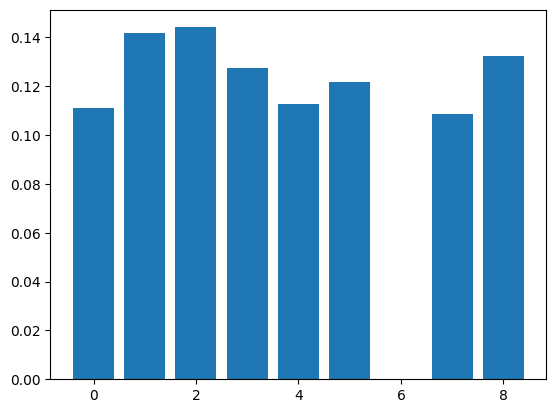

In [58]:
# Showing which features are more important in predicting:

# Changed the asset name from 'NAS:APPL' to 'NAS:AAPL'
importance = models["NAS:AAPL"].feature_importances_

for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

plt.bar([x for x in range(len(importance))], importance)
plt.show()


In [59]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="is_liquid"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_s&p500' (time: 1254, asset: 20)> Size: 201kB
array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [-0.66,  0.82, -0.7 , ...,  0.  , -0.58, -0.62],
       [ 0.48,  0.56,  0.44, ...,  0.  ,  0.56,  0.64],
       [-0.6 , -0.68, -0.64, ...,  0.  , -0.62, -0.62]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:ADBE' ... 'NAS:TSLA' 'NAS:TXN'
  * time     (time) datetime64[ns] 10kB 2020-01-24 2020-01-27 ... 2025-01-17
    field    <U9 36B 'is_liquid'


<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-59-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [60]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

88.51212082356571

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [61]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-13,1.234291e+06,0.016379,0.176727,0.000000,-0.037698,88.933304,15.716934,-0.098182,18.0,0.979415,1.932780
2025-01-14,1.245884e+06,0.009393,0.176659,0.000000,-0.037698,88.932251,15.710658,1.000000,18.0,0.979271,1.932898
2025-01-15,1.255653e+06,0.007841,0.176595,0.000000,-0.037698,88.899630,15.699240,-0.483186,18.0,0.979419,1.933343
2025-01-16,1.276962e+06,0.016970,0.176543,0.000000,-0.037698,89.032456,15.718021,0.866944,18.0,0.979823,1.932908
2025-01-17,1.263218e+06,-0.010763,0.176749,-0.010763,-0.037698,88.512121,15.644424,-1.000000,18.0,0.980354,1.932175


time,2025-01-17
field,
sharpe_ratio,88.512121


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [62]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.8015861254327034

In [63]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.8223526650697517

In [64]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.45589952153109997

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [65]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [66]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="is_liquid"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [67]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


<ipython-input-66-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| |#                                               | 9060 Elapsed Time: 0:00:00
| |          #                                  | 2173150 Elapsed Time: 0:00:01


fetched chunk 1/1 6s
Data loaded 7s


<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...


<ipython-input-66-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

| |#                                               | 9060 Elapsed Time: 0:00:00
| |           #                                 | 2762308 Elapsed Time: 0:00:01


fetched chunk 1/8 2s


| |          #                                  | 2777530 Elapsed Time: 0:00:01


fetched chunk 2/8 5s


| |          #                                  | 2587364 Elapsed Time: 0:00:01


fetched chunk 3/8 7s


| |          #                                  | 3060944 Elapsed Time: 0:00:01


fetched chunk 4/8 10s


| |          #                                  | 3180913 Elapsed Time: 0:00:01


fetched chunk 5/8 12s


| |           #                                 | 3388136 Elapsed Time: 0:00:01


fetched chunk 6/8 15s


| |           #                                 | 3552410 Elapsed Time: 0:00:01


fetched chunk 7/8 18s


| |           #                                 | 3176454 Elapsed Time: 0:00:01


fetched chunk 8/8 20s
Data loaded 22s


| |#                                               | 9060 Elapsed Time: 0:00:00
| |             #                               | 2797062 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |           #                                 | 2926423 Elapsed Time: 0:00:01


fetched chunk 2/7 5s


| |          #                                  | 2879421 Elapsed Time: 0:00:01


fetched chunk 3/7 8s


| |          #                                  | 3056586 Elapsed Time: 0:00:01


fetched chunk 4/7 10s


| |           #                                 | 3345450 Elapsed Time: 0:00:01


fetched chunk 5/7 13s


| |            #                                | 3490958 Elapsed Time: 0:00:01


fetched chunk 6/7 16s


| |           #                                 | 3205090 Elapsed Time: 0:00:01


fetched chunk 7/7 19s
Data loaded 19s
Backtest...


Se han truncado las últimas 5000 líneas del flujo de salida.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-65-3636d5c2d255>:13: FutureWarn

fetched chunk 1/7 3s


| |          #                                  | 2943623 Elapsed Time: 0:00:01


fetched chunk 2/7 5s


| |           #                                 | 2893499 Elapsed Time: 0:00:01


fetched chunk 3/7 8s


| |            #                                | 3082667 Elapsed Time: 0:00:01


fetched chunk 4/7 10s


| |           #                                 | 3374166 Elapsed Time: 0:00:01


fetched chunk 5/7 13s


| |           #                                 | 3522211 Elapsed Time: 0:00:01


fetched chunk 6/7 16s


| |           #                                 | 3230393 Elapsed Time: 0:00:01


fetched chunk 7/7 19s
Data loaded 20s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-17
Sharpe Ratio = -1.5708016104562614


ERROR! The Sharpe Ratio is too low. -1.5708016104562614 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5044 of 5044) |####################| Elapsed Time: 0:11:30 Time:  0:11:30


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!